In [1]:
%run /project2/lgrandi/zhut/Imports.ipynb
sys.modules['admix'] = None
import strax
import straxen
import cutax
#straxen.rucio.HAVE_ADMIX = False

from straxen import get_correction_from_cmt

In [2]:
print('Using cutax version:', cutax.__version__)
st = cutax.contexts.xenonnt_v6(
    output_folder='/dali/lgrandi/zhut/strax_data_processed/',
    )

Using cutax version: 1.3.0


In [3]:
# dsets = st.select_runs(include_tags='_sr0_preliminary', exclude_tags='lt_3d_after_ramp')
# dsets = dsets.loc[dsets['mode']=='tpc_ar37', :]

# nonotags = ['ramp_down', 'warm_spot', 'flash,pmt_trip',
#     'pmt_trip', 'flash,pmt_trip ', '_messy', 'ramp_up', 
#     'ramp_up,lt_3d_after_ramp',
#     'hot_spot,ramp_down', 'hot_spot', 'messy',
#     'warm_spot,lt_3d_after_ramp,lt_24h_after_kr',
#     'kr83m_and_ar37', 'kr38m_and_ar73', 'lt_24h_after_kr',
#     'lt_3d_after_ramp,lt_24h_after_kr', 'kr83m_and_ar37,lt_3d_after_ramp',
# ]

# dsets = dsets.loc[~dsets['tags'].isin(nonotags), :]
# print(len(dsets))
# print(min(dsets['start']), 'to', max(dsets['start']))
# dsets.to_hdf('./ar_datasets.h5', 'table')
# '; '.join(dsets['tags'].unique())

In [4]:
# dsets = st.select_runs(include_tags='_sr0_preliminary', exclude_tags=['lt_3d_after_ramp', 'missing_one_pmt'])
# modes = [m for m in dsets['mode'].unique() if 'kr' in m]
# dsets = dsets.loc[dsets['mode'].isin(modes), :]

# nonotags = ['ramp_down', 'warm_spot', 'flash,pmt_trip',
#     'pmt_trip', 'flash,pmt_trip ', '_messy',
#     'ramp_up', 
#     'ramp_up,lt_3d_after_ramp',
#     'hot_spot,ramp_down', 'hot_spot', 'messy',
#     'warm_spot,lt_3d_after_ramp,lt_24h_after_kr',
#     'kr83m_and_ar37', 'kr38m_and_ar73', 'lt_24h_after_kr',
#     'lt_3d_after_ramp,lt_24h_after_kr', 'kr83m_and_ar37,lt_3d_after_ramp',
# ]
# dsets = dsets.loc[~dsets['tags'].isin(nonotags), :]
# print(len(dsets))
# print(min(dsets['start']), 'to', max(dsets['start']))
# dsets.to_hdf('./kr_datasets.h5', 'table')
# '; '.join(dsets['tags'].unique())

In [5]:
dsets = pd.read_hdf('./kr_datasets.h5', 'table')

In [6]:
st = cutax.contexts.xenonnt_v6()
print('Using cutax version:', cutax.__version__)
cuts_in_use = list(cutax.BasicCuts().depends_on) + ['cut_near_wires']
for each in ['event_info'] + cuts_in_use:
    each_cut_plugin = st._plugin_class_registry[each]
    stored = st.is_stored(dsets.name.values[0], each)
    print("%25s" % each, '\tversion %s' % each_cut_plugin.__version__, "%15s" % stored)

Using cutax version: 1.3.0
               event_info 	version 0.0.2            True
             cut_daq_veto 	version 0.0.3           False
   cut_interaction_exists 	version 0.0.1           False
       cut_clipped_events 	version 0.0.1           False
      cut_fiducial_volume 	version 0.0.0           False
           cut_s1_max_pmt 	version 0.0.1           False
 cut_s1_area_fraction_top 	version 0.0.1           False
    cut_s2_single_scatter 	version 0.0.2           False
             cut_s2_width 	version 0.1.1           False
    cut_s2_recon_pos_diff 	version 0.1.1           False
cut_cs2_area_fraction_top 	version 0.0.0           False
           cut_s1_pattern 	version 0.0.0           False
           cut_s2_pattern 	version 0.0.1           False
    cut_s1_single_scatter 	version 0.1.1           False
           cut_near_wires 	version 0.0.1           False


In [52]:
dsets = pd.read_hdf('./ar_datasets.h5', 'table')
dsets = dsets.sort_values(by='name', axis=0)

# event_info_available = []
# count = 0
# for n in tqdm(dsets.name.values[:]):
#     if count >= 39:
#         event_info_available.append(False)
#     else:
#         event_info_available.append(st.is_stored(n, 'event_info'))
#     count += 1
# print(np.array(event_info_available).sum())

100%|██████████| 38/38 [00:01<00:00, 28.10it/s]

38


In [53]:
# group = dsets.name.values[event_info_available][:]
# # group = [n for n in group if not n in ['018219']] Kr exception

# data = st.get_df(group, ['event_info'] + cuts_in_use,
#                  selection_str=('s2_area > 200',
#                                 'z>-144', 'r<70', 'z<0',
#                                 's1_area < 1e3',
#                                 's1_area_fraction_top<0.65',
#                                ))

Loading 38 runs:   0%|          | 0/38 [00:00<?, ?it/s]

In [54]:
# data.to_hdf('/dali/lgrandi/zhut/strax_data_processed/batch_b_ar.h5', 'table')
# data.to_hdf('/dali/lgrandi/zhut/strax_data_processed/batch_b_kr.h5', 'table')

In [55]:
data_ar = pd.read_hdf('/dali/lgrandi/zhut/strax_data_processed/batch_b_ar.h5', 'table')
data_kr = pd.read_hdf('/dali/lgrandi/zhut/strax_data_processed/batch_b_kr.h5', 'table')

In [56]:
def apply_all_except(data, cuts_in_use, except_cuts=None):
    mask = np.ones(len(data), dtype=np.bool)
    if except_cuts is None:
        except_cuts = []

    if not isinstance(except_cuts, list):
        except_cuts = [except_cuts]

    for cut in cuts_in_use:
        if cut in except_cuts:
            # print('found cut %s in skip'%cut)
            continue
        if '~'+cut in except_cuts:
            mask &= ~data[cut]
            # print('apply oppo cut %s'%cut)
            continue
        # print('apply cut %s'%cut)
        mask &= data[cut]

    return mask

In [57]:
import strax
import numpy as np
from scipy.stats import chi2
from scipy.stats import norm
from scipy.interpolate import interp1d
from straxen.get_corrections import get_correction_from_cmt


@strax.takes_config(
    strax.Option('min_s2_area_width_cut', default=0,
                 help='Min area [PE] of a S2 for the S2WidthCut'),
    strax.Option('max_s2_area_width_cut', default=1e8,
                 help='Max area [PE] of a S2 for the S2WidthCut'),
    strax.Option('electron_drift_velocity',
                 default=("electron_drift_velocity", "ONLINE", True),
                 help='Vertical electron drift velocity in cm/ns (1e4 m/ms)',
                 ),
    strax.Option('electron_drift_time_gate',
                 default=("electron_drift_time_gate", "ONLINE", True),
                 help='Drift time of the gate in ns.',
                 ),
    strax.Option('diffusion_constant', default=4.447e-8,
                 help='Diffusion constant used in S2WidthCut [cm^2/ns]'),
    strax.Option('s2_secondary_sc_gain', default=23,
                 help=('S2 secondary sc gain for the S2WidthCut. '
                       'THIS VALUE IS DEPRECATED.')),
    strax.Option('s2_secondary_sc_width', default=375,
                 help=('S2 secondary sc width median for the S2WidthCut. '
                       'THIS VALUE IS DEPRECATED.')),
    strax.Option('min_norm_s2_width_cut', default=-14,
                 help='Minimum Chi2 norm of S2 width cut'),
    strax.Option('switch_from_chi2', default=10**4.1,
                 help=('S2 area value where to switch from chi2.ppf '
                       'to a parabola on the cut line.')),
    strax.Option('param_parabola_high', default=(0.05175732, -0.45385021,  2.2307461),
                 help=('Parameters of the polynomial function to apply at '
                 'high energy as an upper boundary [deg2, deg1, deg0]')),
    strax.Option('param_parabola_low', default=(0.05175732, -0.45385021,  1.76927997),
                 help=('Parameters of the polynomial function to apply at '
                 'high energy as a lower boundary [deg2, deg1, deg0]')),      
)
class S2WidthStrict(strax.CutPlugin):
    """
    Cut on S2 width based on preliminary boundaries for SR0.
    The current version divides the cut into two regions: below and
    above 1e4.1 PE on S2 area. The region below is cut by a chi2.ppf
    function and the region above is cut by a parabola due an increase
    of width at high energies.
    To be updated:
      - Add dependence on xy due to wires;
      - Return the cut with updated diffusion, SE gain and SE width
      - Go to chi2.pdf instead of np.sqrt(chi2.ppf(...))
    Current developers: rperes@physik.uzh.ch; valerio.dandrea@lngs.infn.it
    First implementation and pretty code: j.angevaare@nikhef.nl
    Notes:
      * v0.1.0: dandrea:s2widthcutsr0regionalmeeting
      * v0.0.0: xenon:xenon1t:sim:notes:tzhu:width_cut_tuning
    """
    depends_on = ('event_basics',)
    provides = 'cut_s2_width_strict'
    cut_name = 'cut_s2_width_strict'
    cut_description = 'Strict S2Width (particularly near wires)'
    __version__ = '0.1.1'

    def setup(self):
        self.electron_drift_velocity = get_correction_from_cmt(
            self.run_id,
            self.config['electron_drift_velocity'])
        self.electron_drift_time_gate = get_correction_from_cmt(
            self.run_id,
            self.config['electron_drift_time_gate'])
        self.sigma_to_r50p = norm.ppf(0.75) - norm.ppf(0.25)

    def s2_width_model(self, drift_time):
        return self.sigma_to_r50p * np.sqrt(2 * self.config['diffusion_constant'] *
                                            (drift_time - self.electron_drift_time_gate) / self.electron_drift_velocity**2 +
                                            self.config['s2_secondary_sc_width']**2)

    def position_resolution(self, s2_area_top):
            return 0.14 + (8e2 / np.clip(s2_area_top, 0, 3e3)) ** 0.64

    def uppper_lim_with_wire(self, model_pred, nwidth_lim, s2_area_top, x_to_wire):
        ry = model_pred * (nwidth_lim - 1)
        rx = self.position_resolution(s2_area_top) * norm.isf(0.02)
        
        x_tmp = x_to_wire / rx
        k0 = 5e3 * rx / ry  # slope in rescaled space
        y0 = 1 / np.cos(np.arctan(k0))  # interception of the upper limit
        x0 = np.sin(np.arctan(k0))  # switch poit from linear to circle
        yc = 9e3 / ry  # interception of the center

        y_linear = y0 + yc - np.abs(x_tmp) * k0
        y_circle = yc + np.sqrt(1 - np.clip(np.abs(x_tmp)**2, 0, 1))

        y_lim = np.select([np.abs(x_tmp) > x0, np.abs(x_tmp) <= x0],
                          [y_linear, y_circle],
                          1)
        m = y_lim > yc
        y_lim[m] = (y_lim[m] - yc[m]) * 0.5 + yc[m]  # half the peak
        return np.clip(y_lim, 1, np.inf) * ry

    def correct_cut_boundaries(self, area, mask):
        """Forces to accept events tha tare outside the cut defined
        tested boundaries"""
        mask[area > self.config['max_s2_area_width_cut']] = True
        mask[area < self.config['min_s2_area_width_cut']] = True
        return mask 

    def n_electron(self, area):
        return np.clip(area, 0, np.inf) / self.config['s2_secondary_sc_gain']

    def cut_chi2(self, area, band):
        """
        Cut based on the chi2.ppf distribution.
        Params:
          * area: aree [pe] of the peak
          * band: True for upper boundary cut, False for lower boundary cut.
        """
        _n_electron = self.n_electron(area)
        if band:
            return np.sqrt(chi2.ppf((1 - 10 ** self.config['min_norm_s2_width_cut']), _n_electron) / (_n_electron - 1))
        else:
            return np.sqrt(chi2.ppf((10 ** self.config['min_norm_s2_width_cut']), _n_electron) / (_n_electron - 1))

    def cut_parabola(self, area, par2, par1, par0):
        """Returns the value of the 2nd deg polynomial cut
        function at the given area"""
        return par2 * np.power(np.log10(area), 2) + par1 * np.log10(area) + par0

    def get_cut_masks(self, events):
        area = events['s2_area']
        area_top = events['s2_area'] * events['s2_area_fraction_top']
        width = events['s2_range_50p_area']
        model_pred = self.s2_width_model(events['drift_time'])
        x_to_wire = np.abs(events['s2_x_cnn'] * np.cos(-np.pi/6) + events['s2_y_cnn'] * np.sin(-np.pi/6)) - 13.2

        mask_high_chi2     = ((area >= self.config['switch_from_chi2']) |
                              (width - model_pred < self.uppper_lim_with_wire(
                                  model_pred, self.cut_chi2(area, True),
                                  area_top, x_to_wire)))

        mask_high_parabola = ((area < self.config['switch_from_chi2']) |
                              (width - model_pred < self.uppper_lim_with_wire(
                                  model_pred, self.cut_parabola(area, *self.config['param_parabola_high']),
                                  area_top, x_to_wire)))

        mask_low_chi2      = ((area >= self.config['switch_from_chi2']) | 
                              ((width / model_pred) > self.cut_chi2(area, False)))

        mask_low_parabola  = ((area < self.config['switch_from_chi2']) |
                              ((width / model_pred) > self.cut_parabola(area, *self.config['param_parabola_low'])))

        mask_high_chi2 = self.correct_cut_boundaries(area, mask_high_chi2)
        mask_high_parabola = self.correct_cut_boundaries(area, mask_high_parabola)
        mask_low_chi2 = self.correct_cut_boundaries(area, mask_low_chi2)
        mask_low_parabola = self.correct_cut_boundaries(area, mask_low_parabola)

        return mask_high_chi2, mask_high_parabola, mask_low_chi2, mask_low_parabola

    def cut_by(self, events):
        mask_high_chi2, mask_high_parabola, mask_low_chi2, mask_low_parabola = self.get_cut_masks(events)

        cut_mask = (mask_high_chi2 &
                    mask_high_parabola &
                    mask_low_chi2 &
                    mask_low_parabola)

        return cut_mask

In [59]:
s2w = S2WidthStrict()
s2w.run_id = dsets.name.values[-1]
def _set_plugin_config(p, run_id, tolerant=True):
    config = dict()
    for opt in p.takes_config.values():
        try:
            opt.validate(config,
                         run_id=run_id,
                         )
        except strax.InvalidConfiguration:
            if not tolerant:
                raise

    p.config = {k: v for k, v in config.items()
                if k in p.takes_config}
    
_set_plugin_config(s2w, s2w.run_id)
s2w.setup()


s2wt = cutax.cuts.s2_width.S2WidthStrict()
s2wt.run_id = dsets.name.values[0]
_set_plugin_config(s2wt, s2wt.run_id)
s2wt.setup()


s2w_ori = cutax.cuts.s2_width.S2Width()
s2w_ori.run_id = dsets.name.values[0]
_set_plugin_config(s2w_ori, s2w_ori.run_id)
s2w_ori.setup()

In [60]:
# fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# data = data_kr

# masks = apply_all_except(data, cuts_in_use, ['cut_s2_single_scatter', 'cut_s2_pattern']), apply_all_except(data, cuts_in_use, 'cut_s2_pattern')
# for ix, m in enumerate(masks):
#     plt.scatter(data['s2_area'][m], 
#                 data['alt_s2_area'][m], 
#                 s=10, color='C%d'%ix, alpha=0.7, ec='none'
#                )

# plt.xlim(2, 1e5)
# plt.ylim(2, 1e5)

# @np.errstate(over='ignore')
# def fermi_dirac_low_s2(s2_area, k, b, bound, coeff):
#     return (k*s2_area + b)/( 1 + np.exp(coeff * (s2_area-bound)))


# @np.errstate(over='ignore')
# def fermi_dirac_high_s2(s2_area, k, b, bound, coeff):
#     return (k*s2_area + b)/( 1 + np.exp(coeff * (bound-s2_area)))


# def s2_single_scatter_cut(s2_area, config):
#     max_allowed_alt_s2_area = fermi_dirac_low_s2(s2_area, 
#         config['min_allowed_alt_s2_area_slope_low_s2'], 
#         config['min_allowed_alt_s2_area_offset_low_s2'],
#         config['boundary_low_and_high_s2'], 
#         config['coeffcient_fermi_dirac'])
#     max_allowed_alt_s2_area += fermi_dirac_high_s2(s2_area,  
#         config['min_allowed_alt_s2_area_slope_high_s2'], 
#         config['min_allowed_alt_s2_area_offset_high_s2'],
#         config['boundary_low_and_high_s2'], 
#         config['coeffcient_fermi_dirac'])
#     return max_allowed_alt_s2_area

# s2_single_scatter_cut_config = dict(
#     min_allowed_alt_s2_area_offset_low_s2=120,
#     min_allowed_alt_s2_area_slope_low_s2=0.00123,
#     min_allowed_alt_s2_area_offset_high_s2=410,
#     min_allowed_alt_s2_area_slope_high_s2=0.00073,
#     boundary_low_and_high_s2=30000,
#     coeffcient_fermi_dirac=5e-4,
# )


# s2_area = np.geomspace(20, 1e6, num=101)
# plt.plot(s2_area, s2_single_scatter_cut(s2_area, s2_single_scatter_cut_config), color='r')
# plt.plot(s2_area, s2_area * 0.123 + 420, color='m')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('S1_area')
# plt.ylabel('alt_S1_area')

# plt.show()

In [61]:
data_ar['cut_s2_width_mod'] = s2w.cut_by(data_ar)
data_ar['cut_s2_width_tight'] = s2wt.cut_by(data_ar)
data_ar['cut_s2_width'] = s2w_ori.cut_by(data_ar)

In [62]:
data_ar['cut_s1_single_scatter_mod'] = ~ (data_ar['alt_s1_area'] > 200) 
data_ar['cut_s2_area_range_mod'] = (data_ar['s2_area'] > 700) & (data_ar['s2_area'] < 3e3)
data_ar['cut_s2_single_scatter_mod'] = ~ (data_ar['alt_s2_area'] > data_ar['s2_area'] * 0.123 + 420)
data_ar['cut_not_near_wires'] = ~ data_ar['cut_near_wires']
data_ar['cut_aux'] = data_ar['s2_range_50p_area'] < - data_ar['z'] * 5000 + 1000

In [63]:
data_kr['cut_s2_width_mod'] = s2w.cut_by(data_kr)
data_kr['cut_s2_width_tight'] = s2wt.cut_by(data_kr)

In [64]:
data_kr['cut_s1_single_scatter_mod'] = ~ (data_kr['alt_s1_area'] > 200) 
data_kr['cut_s2_area_range_mod'] = (data_kr['s2_area'] > 2e3) & (data_kr['s2_area'] < 3e4)
data_kr['cut_s2_single_scatter_mod'] = ~ (data_kr['alt_s2_area'] > data_kr['s2_area'] * 0.123 + 420)
data_kr['cut_not_near_wires'] = ~ data_kr['cut_near_wires']
data_kr['cut_aux'] = data_kr['s2_range_50p_area'] < - data_kr['z'] * 5000 + 1000

In [65]:
cuts_in_use_mod = list(cutax.BasicCuts().depends_on)
cuts_in_use_mod = [c for c in cuts_in_use_mod if not c in 
               ['cut_fiducial_volume', 'cut_s1_single_scatter', 'cut_s2_single_scatter', 'cut_near_wires', 'cut_s2_pattern']]
cuts_in_use_mod += ['cut_s1_single_scatter_mod', 'cut_s2_single_scatter_mod', 'cut_s2_width_mod', 'cut_s2_area_range_mod', 'cut_aux', 'cut_not_near_wires']
cuts_in_use_mod

['cut_daq_veto',
 'cut_interaction_exists',
 'cut_clipped_events',
 'cut_s1_max_pmt',
 'cut_s1_area_fraction_top',
 'cut_s2_width',
 'cut_s2_recon_pos_diff',
 'cut_cs2_area_fraction_top',
 'cut_s1_pattern',
 'cut_s1_single_scatter_mod',
 'cut_s2_single_scatter_mod',
 'cut_s2_width_mod',
 'cut_s2_area_range_mod',
 'cut_aux',
 'cut_not_near_wires']

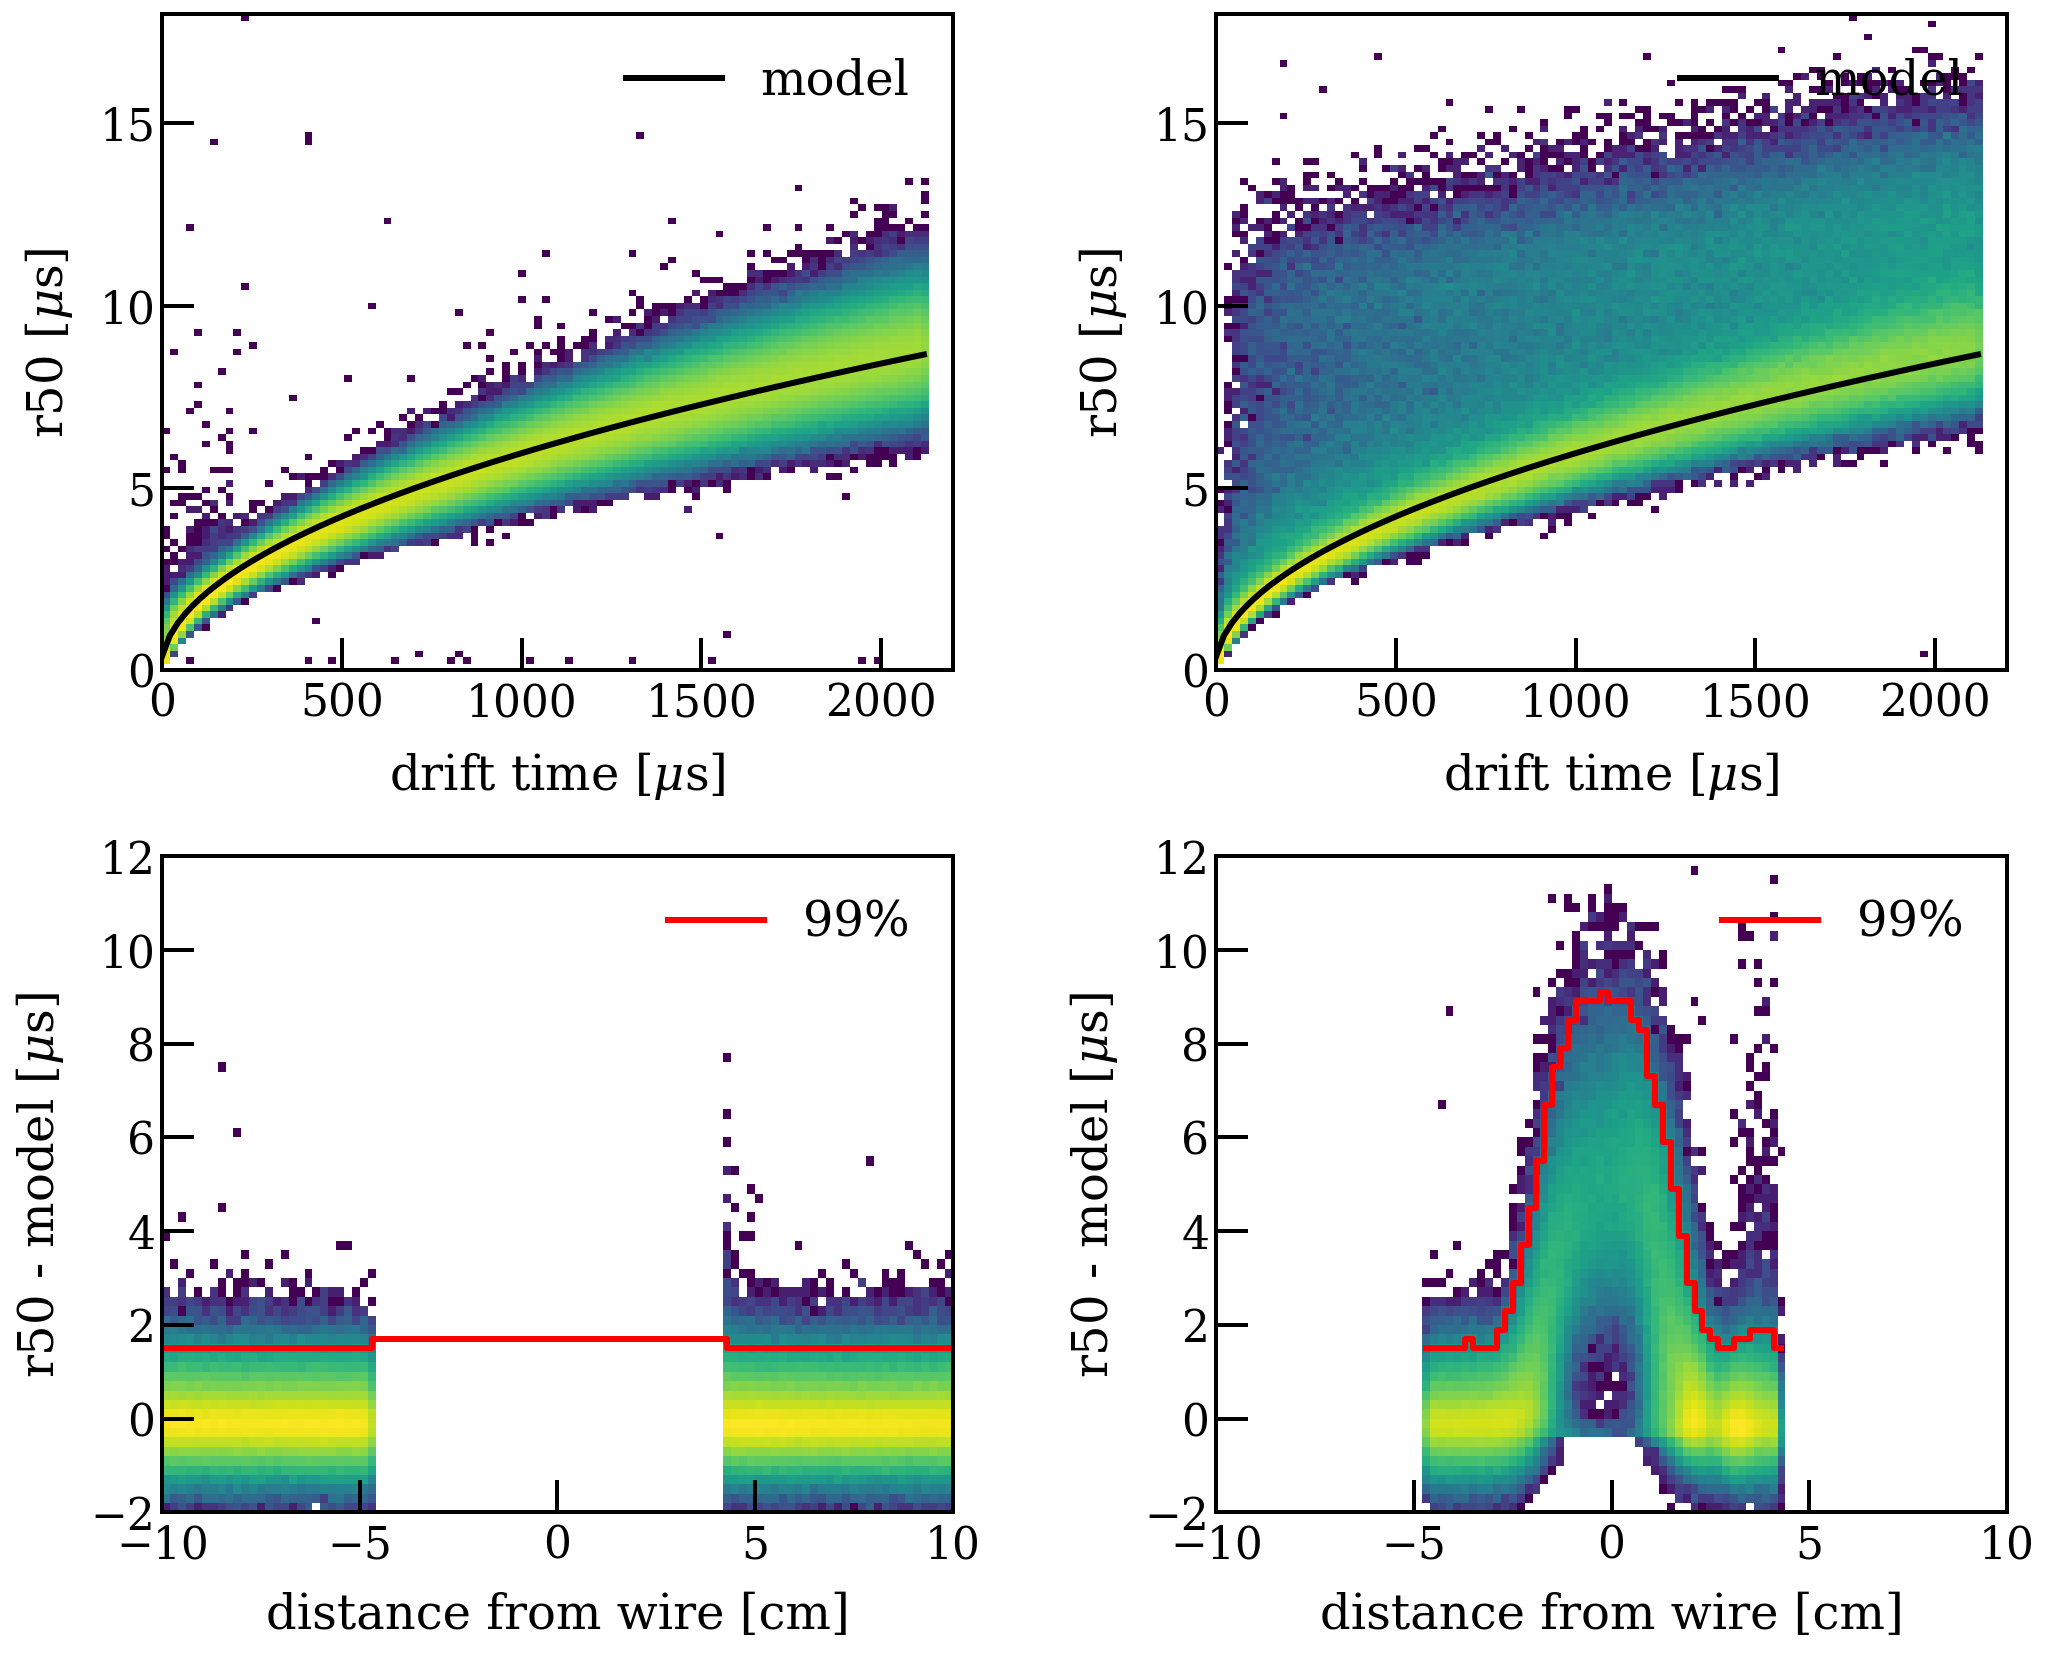

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

hist = True
xbin = [0, 2.2e3, 101]
ybin = [0, 18, 101]

data = data_kr
# A
masks = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod', 'cut_s2_pattern']), \
        apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod', '~cut_not_near_wires', 'cut_s2_pattern'])
for ix, m in enumerate(masks):
    plt.sca(axes[0][ix])
    if hist:
        mh = Histdd(data['drift_time'][m] / 1e3, 
                    data['s2_range_50p_area'][m] / 1e3,
                    bins=[np.linspace(*xbin), np.linspace(*ybin)]
                   )
        ix = 0
        mh.plot(cmap=['viridis', 'autumn_r'][ix], colorbar=False, alpha=1, log_scale=True)

    dt = np.linspace(0, 2.12e6, 101)
    l0, = plt.plot(dt / 1e3, s2w.s2_width_model(dt) / 1e3, color='k')
    
    plt.legend([l0], ['model'])

    plt.xlim(xbin[:2])
    plt.ylim(ybin[:2])

    plt.xlabel('drift time [$\mu$s]')
    plt.ylabel('r50 [$\mu$s]')
#plt.show()


#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
xbin = [-10, 10, 101]
ybin = [-5, 15, 101]

# D
masks = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod']), apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod', '~cut_not_near_wires'])
data['x_to_wire'] = np.abs(data['s2_x_mlp'] * np.cos(-np.pi/6) + data['s2_y_mlp'] * np.sin(-np.pi/6)) - 13.3

for ix, m in enumerate(masks):
    plt.sca(axes[1][ix])
    if hist:
        mh = Histdd(data['x_to_wire'][m], 
                    (data['s2_range_50p_area'][m] - s2w.s2_width_model(data['drift_time'][m])) / 1e3,
                    bins=[np.linspace(*xbin), np.linspace(*ybin)]
                   )
        ix = 0
        mh.plot(cmap=['viridis', 'autumn_r'][ix], colorbar=False, alpha=1, log_scale=True)
        ph = mh.percentile(99, axis=1)
        
        temp_m = ph.histogram > 0
        l0, = plt.step(ph.bin_centers[temp_m], ph.histogram[temp_m], color='r')
    
    plt.legend([l0], ['99%'])
    plt.xlabel('distance from wire [cm]')
    plt.ylabel('r50 - model [$\mu$s]')

    plt.xlim(-10, 10)
    plt.ylim(-2, 12)

plt.tight_layout()
plt.show()

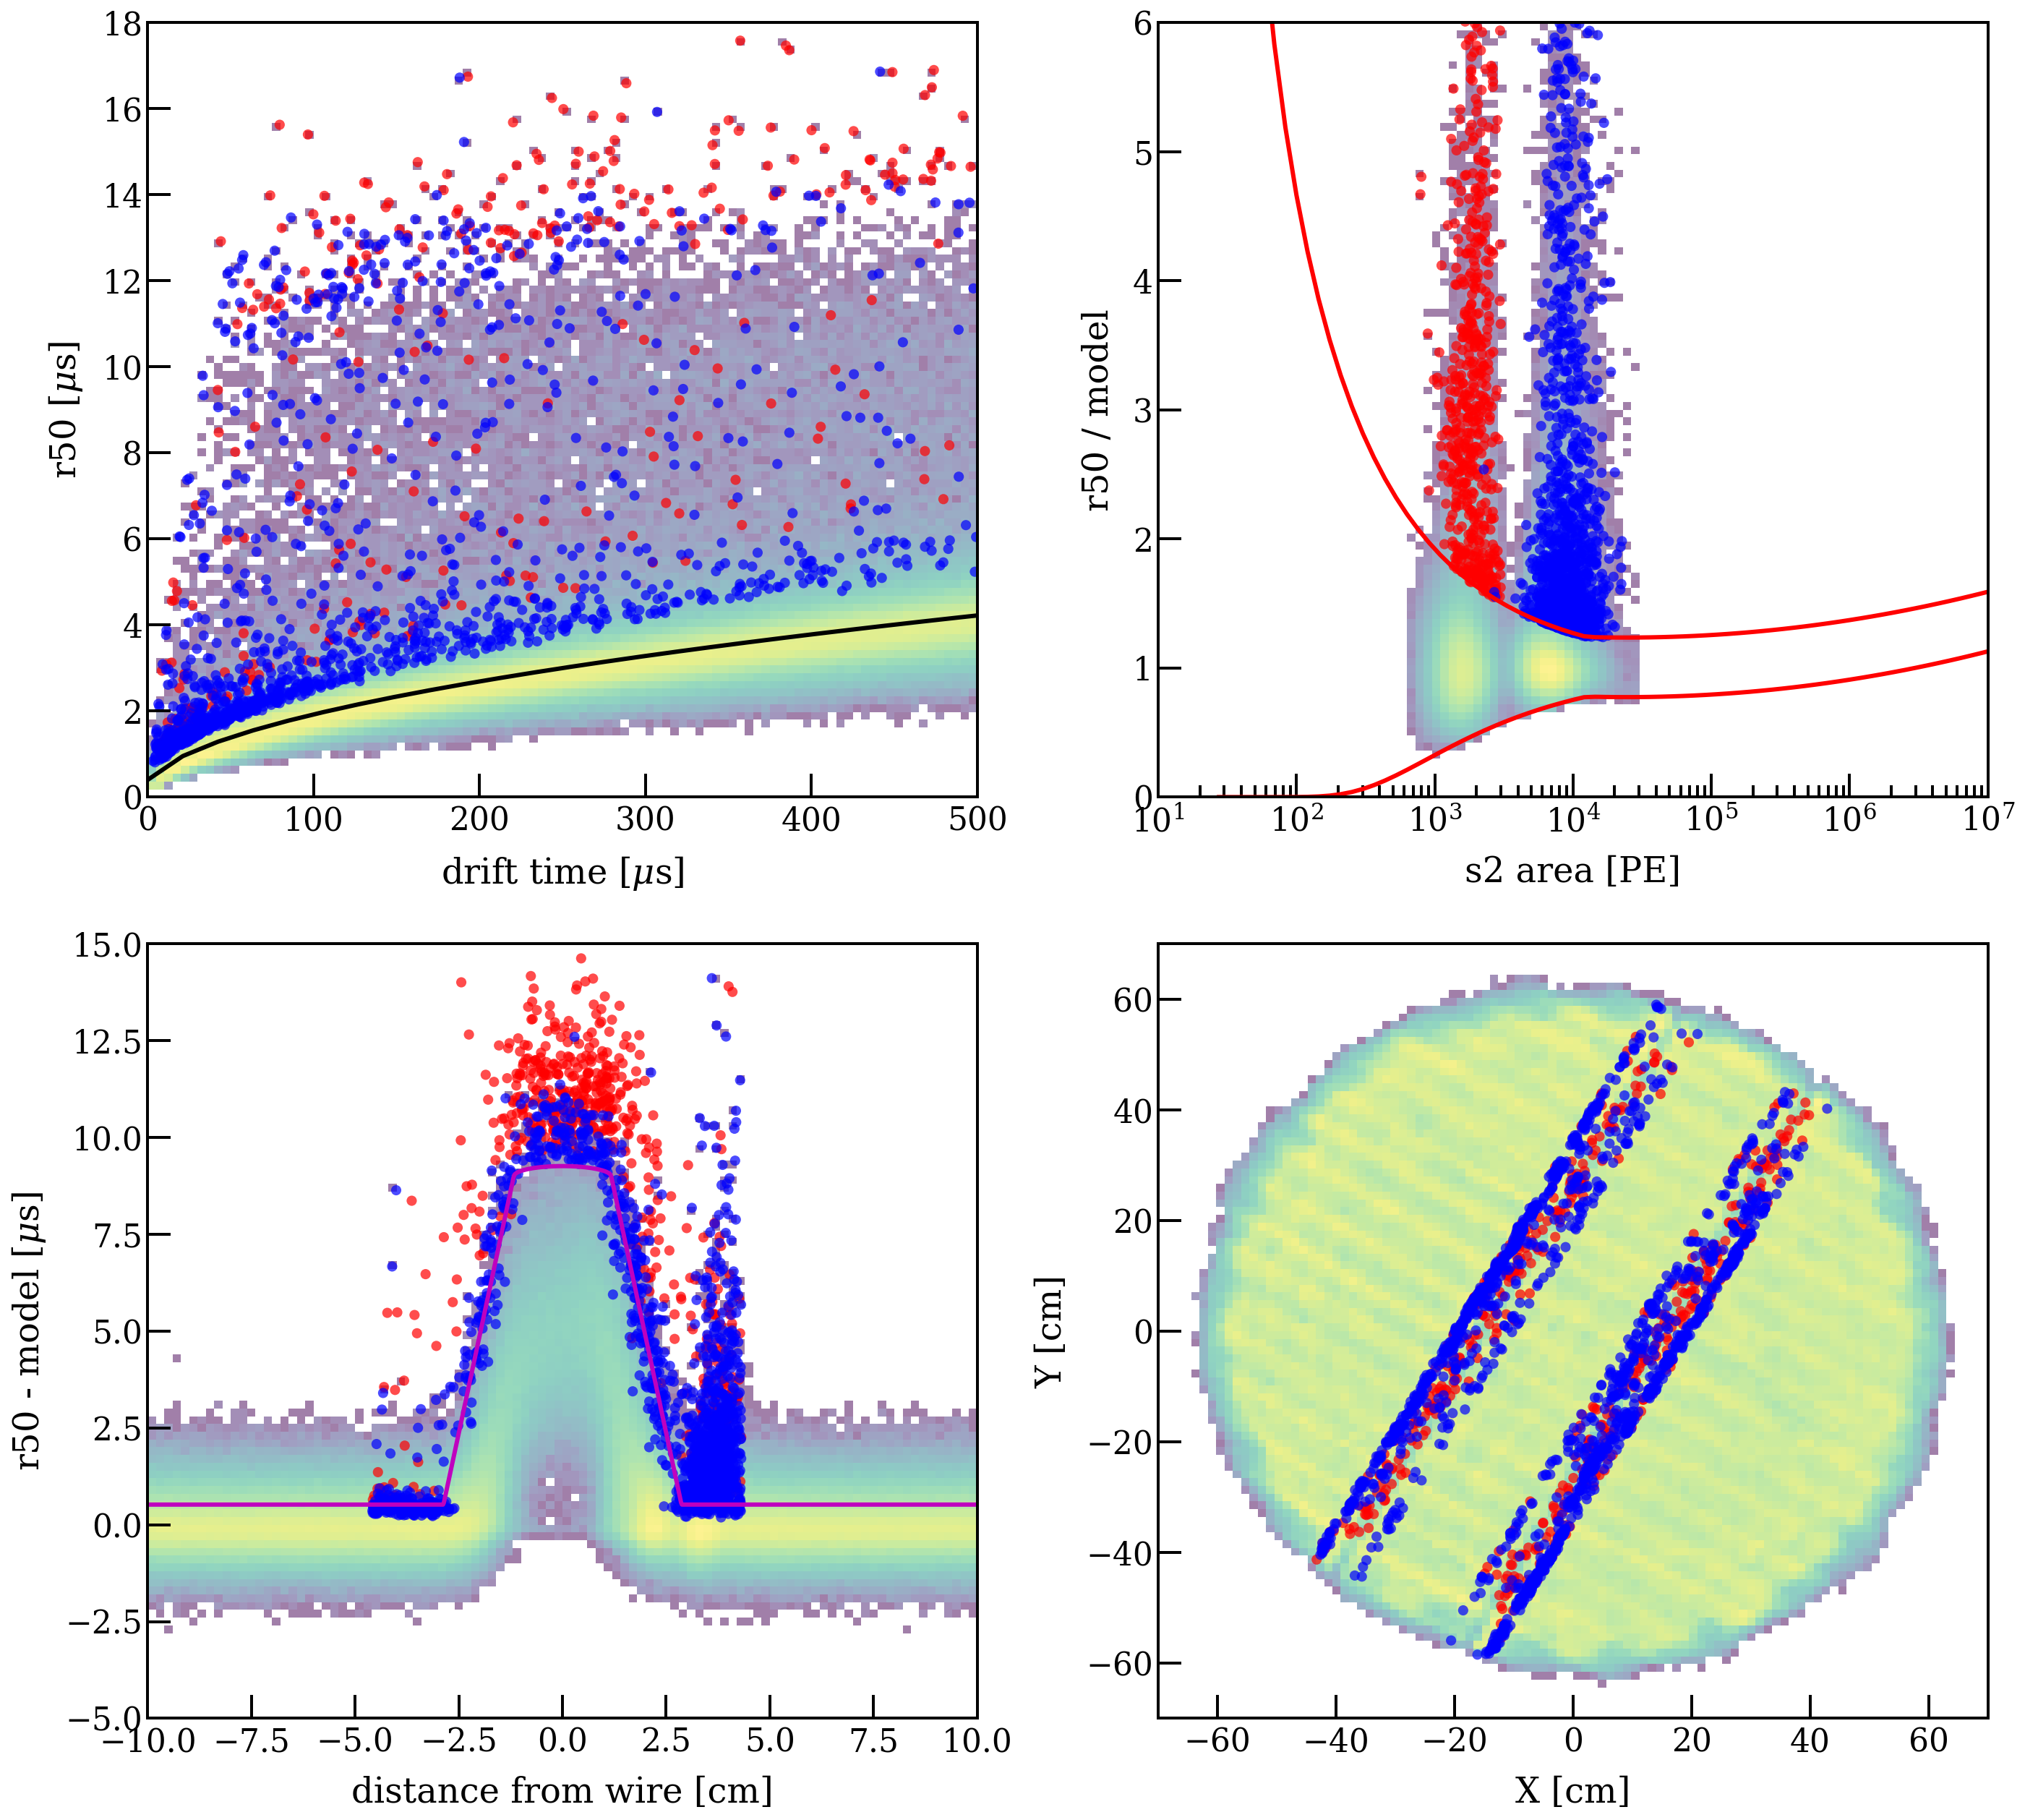

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

hist = True
# A
plt.sca(axes[0][0])

xbin = [0, 0.5e3, 101]
#xbin = [0, 300, 101]
ybin = [0, 18, 101]

mask_string = """
masks = apply_all_except(data, cuts_in_use_mod, ['cut_not_near_wires', 'cut_s2_width_mod']), \
        apply_all_except(data, cuts_in_use_mod, ['cut_not_near_wires', '~cut_s2_width_mod'])
"""

mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
for jx, data in enumerate([data_ar, data_kr]):
    exec(mask_string)
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['drift_time'][m] / 1e3, data['s2_range_50p_area'][m] / 1e3)
        if (not hist) or ix == 1:
            plt.scatter(data['drift_time'][m] / 1e3, 
                        data['s2_range_50p_area'][m] / 1e3, 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )
mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
dt = np.linspace(0, 2.12e6, 101)
plt.plot(dt / 1e3, s2w.s2_width_model(dt) / 1e3, color='k')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])

plt.xlabel('drift time [$\mu$s]')
plt.ylabel('r50 [$\mu$s]')


# B
plt.sca(axes[0][1])
xbin = [1, 7, 101]
ybin = [0, 6, 101]

mh =  Histdd([], [], bins=[np.logspace(*xbin), np.linspace(*ybin)])
for jx, data in enumerate([data_ar, data_kr]):
    exec(mask_string)
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['s2_area'][m], data['s2_range_50p_area'][m] / s2w.s2_width_model(data['drift_time'][m]))
        if (not hist) or ix == 1:
            plt.scatter(data['s2_area'][m], 
                        data['s2_range_50p_area'][m] / s2w.s2_width_model(data['drift_time'][m]), 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )
mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)


s2_area = np.logspace(0, 8, 101)
plt.plot(s2_area, np.select([s2_area <= s2w.config['switch_from_chi2'], s2_area > s2w.config['switch_from_chi2']],
                            [s2w.cut_chi2(s2_area, True), s2w.cut_parabola(s2_area, *s2w.config['param_parabola_high'])], 1), 
         color='r')

plt.plot(s2_area, np.select([s2_area <= s2w.config['switch_from_chi2'], s2_area > s2w.config['switch_from_chi2']],
                            [s2w.cut_chi2(s2_area, False), s2w.cut_parabola(s2_area, *s2w.config['param_parabola_low'])], 1), 
         color='r')

plt.xlim(10**np.array(xbin[:2]))
plt.ylim(ybin[:2])

plt.xscale('log')
plt.xlabel('s2 area [PE]')
plt.ylabel('r50 / model')


# C
plt.sca(axes[1][0])
xbin = [-10, 10, 101]
ybin = [-5, 15, 101]

for jx, data in enumerate([data_ar, data_kr]):
    exec(mask_string)
    data['x_to_wire'] = np.abs(data['s2_x_mlp'] * np.cos(-np.pi/6) + data['s2_y_mlp'] * np.sin(-np.pi/6)) - 13.2
    mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['x_to_wire'][m], (data['s2_range_50p_area'][m] - s2w.s2_width_model(data['drift_time'][m])) / 1e3,)
        if (not hist) or ix == 1:
            plt.scatter(data['x_to_wire'][m],
                        (data['s2_range_50p_area'][m] - s2w.s2_width_model(data['drift_time'][m])) / 1e3, 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )

mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
x2w = np.linspace(-10, 10, 1001)
x1 = np.ones_like(x2w)
plt.plot(x2w, s2w.uppper_lim_with_wire(x1 * s2w.s2_width_model(100e3), 
                                       x1 * s2w.cut_chi2(1e4, True), 
                                       x1 * 1e4 * 0.75, x2w) / 1e3, color='m')
    
plt.xlabel('distance from wire [cm]')
plt.ylabel('r50 - model [$\mu$s]')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])


# D
plt.sca(axes[1][1])
xbin = [-70, 70, 101]
ybin = [-70, 70, 101]

for jx, data in enumerate([data_ar, data_kr]):
    exec(mask_string)
    mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['s2_x'][m], data['s2_y'][m],)
                
        if (not hist) or ix == 1:
            plt.scatter(data['s2_x'][m],
                        data['s2_y'][m],
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )

mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])

plt.tight_layout()
plt.show()

In [69]:
import statsmodels.api as sm
sm_interval = sm.stats.proportion_confint

In [70]:
from pprint import pprint
def c(x):
    return 0.5*(x[1:]+x[:-1])

#s1_area_bins = np.geomspace(100, 1000, num=15)
#s2_area_bins = np.geomspace(200, 50000, num=15)

s1_area_bins = np.linspace(200, 600, num=15)
s2_area_bins = np.linspace(0, 15000, num=15)

s1_bins_center = c(s1_area_bins)
s2_bins_center = c(s2_area_bins)

s1_variable = 's1'
s2_variable = 's2'


r2_bins = np.linspace(0, 4500, num=15)
z_bins = np.linspace(-100, 0, num=15)
xr_bins = np.linspace(0, 70, num=15)

r2_bins_center = c(r2_bins)
z_bins_center = c(z_bins)
xr_bins_center = c(xr_bins)

In [72]:
cuts_in_use_mod = list(cutax.BasicCuts().depends_on)
cuts_in_use_mod = [c for c in cuts_in_use_mod if not c in 
               ['cut_fiducial_volume', 'cut_s1_single_scatter', 'cut_s2_single_scatter', 'cut_near_wires', 'cut_s2_pattern']]
cuts_in_use_mod += ['cut_s1_single_scatter_mod', 'cut_s2_single_scatter_mod', 'cut_s2_width_mod', 'cut_s2_area_range_mod', 'cut_aux',]
cuts_in_use_mod

['cut_daq_veto',
 'cut_interaction_exists',
 'cut_clipped_events',
 'cut_s1_max_pmt',
 'cut_s1_area_fraction_top',
 'cut_s2_width',
 'cut_s2_recon_pos_diff',
 'cut_cs2_area_fraction_top',
 'cut_s1_pattern',
 'cut_s1_single_scatter_mod',
 'cut_s2_single_scatter_mod',
 'cut_s2_width_mod',
 'cut_s2_area_range_mod',
 'cut_aux']

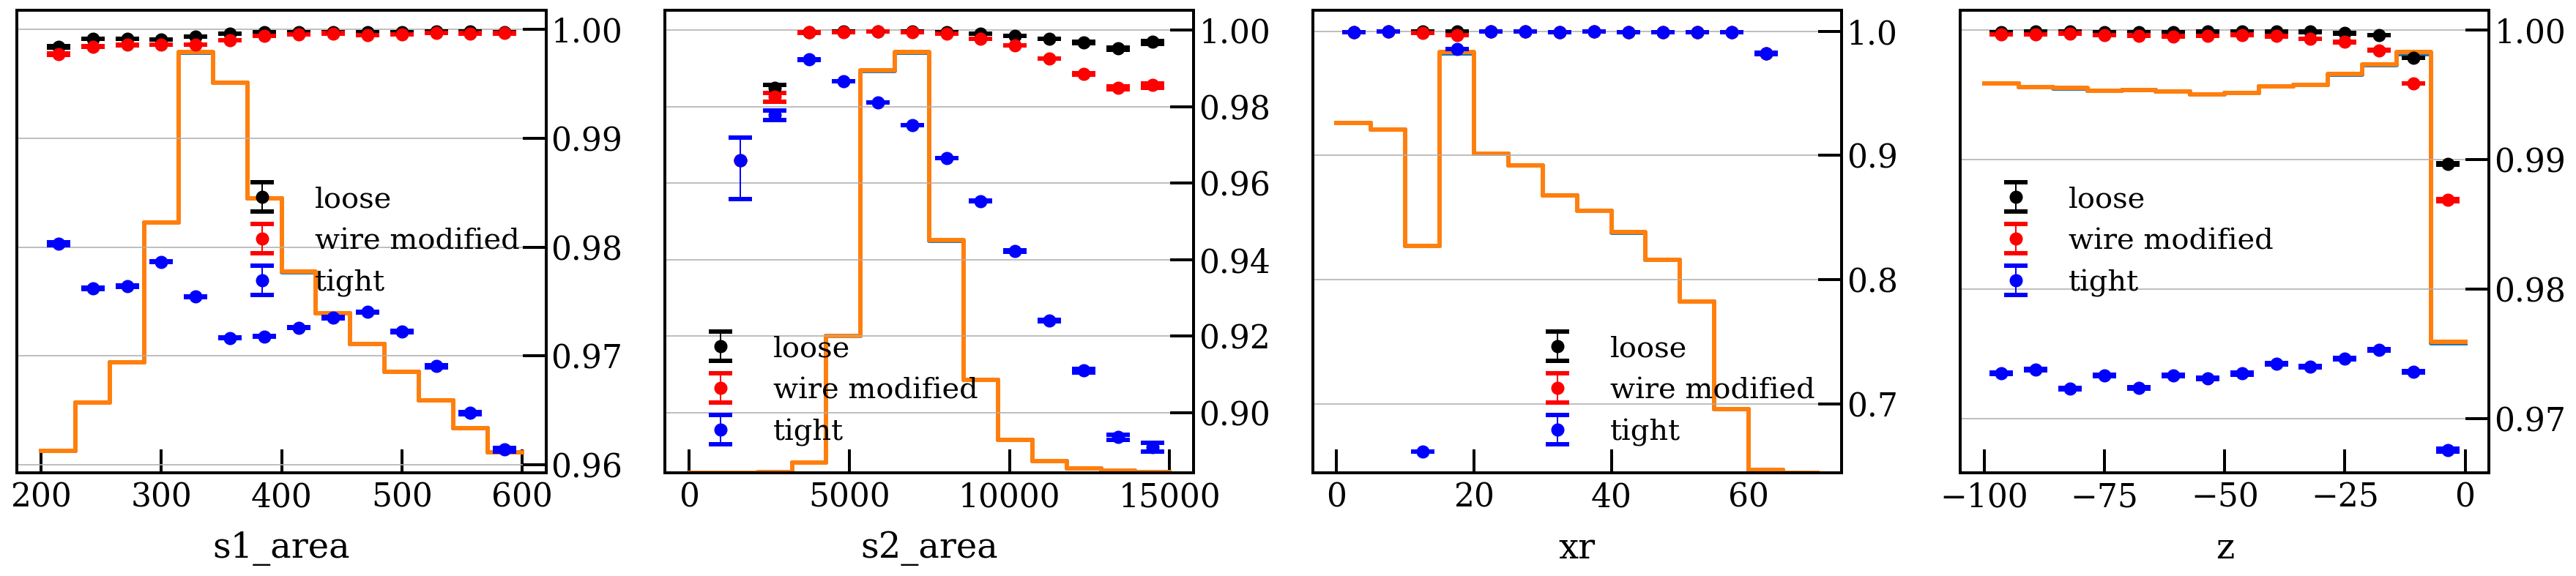

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6), sharey=False)

s1_area_bins = np.linspace(200, 600, num=15)
s2_area_bins = np.linspace(0, 15000, num=15)
s1_bins_center = c(s1_area_bins)
s2_bins_center = c(s2_area_bins)


data_kr['xr'] = np.abs(data_kr['s2_x_mlp'] * np.cos(-np.pi/6) + data_kr['s2_y_mlp'] * np.sin(-np.pi/6))
data_kr['r2'] = data_kr['y'] ** 2 + data_kr['x'] ** 2
data = data_kr
diagnostic_plot = True
for ix, x_var in enumerate(('s1_area', 's2_area', 'xr', 'z')[:]):
    plt.sca(axes[ix])
    axt = plt.gca().twinx()

    ls = []
    for iy in range(3):
        plt.sca(axes[ix])
        if iy == 0:
            sel_all = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width_mod']) & (data['z'] < -5)
        if iy == 1:
            sel_all = apply_all_except(data, cuts_in_use_mod) & (data['z'] < -5)
        if iy == 2:
            sel_all = apply_all_except(data, cuts_in_use_mod) & (data['z'] < -5) & data['cut_s2_width_tight']
        
        sel_n_1 = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod'])  & (data['z'] < -5)

        pha = Hist1d(data[x_var][sel_all], bins=eval(x_var+'_bins'))
        pht = Hist1d(data[x_var][sel_n_1], bins=eval(x_var+'_bins'))

        if diagnostic_plot:
            if iy == 1:
                pha.plot()
                pht.plot()

                axes[ix].set_ylim(0, np.max(pht[:])*1.1)
                axes[ix].get_yaxis().set_visible(False)

            plt.xlabel(x_var)
            plt.sca(axt)

        ci_low = np.zeros(len(pha[:]))
        ci_upp = np.zeros(len(pha[:]))
        for j in range(len(pha)):
             ci_low[j], ci_upp[j] = sm_interval(pha[j], pht[j], alpha=0.9, method='beta')

        if ix <= 1:
            x = eval(x_var[:-5]+'_bins_center')
        else:
            x = eval(x_var[:]+'_bins_center')
        y = pha[:] / pht[:]
        ci_low = y - ci_low
        ci_upp = ci_upp - y
        yerr = np.array([ci_low, ci_upp])
        l = plt.errorbar(x, y, yerr, lw=1, fmt='.', alpha=1, color=['k', 'r', 'b'][iy], )
        ls.append(l)

    plt.grid()
    plt.xlabel(x_var)
    plt.legend(ls, ['loose', 'wire modified', 'tight'], fontsize='small')

    # if ix <= 1:
    #     plt.xscale('log')

plt.tight_layout()
plt.show()

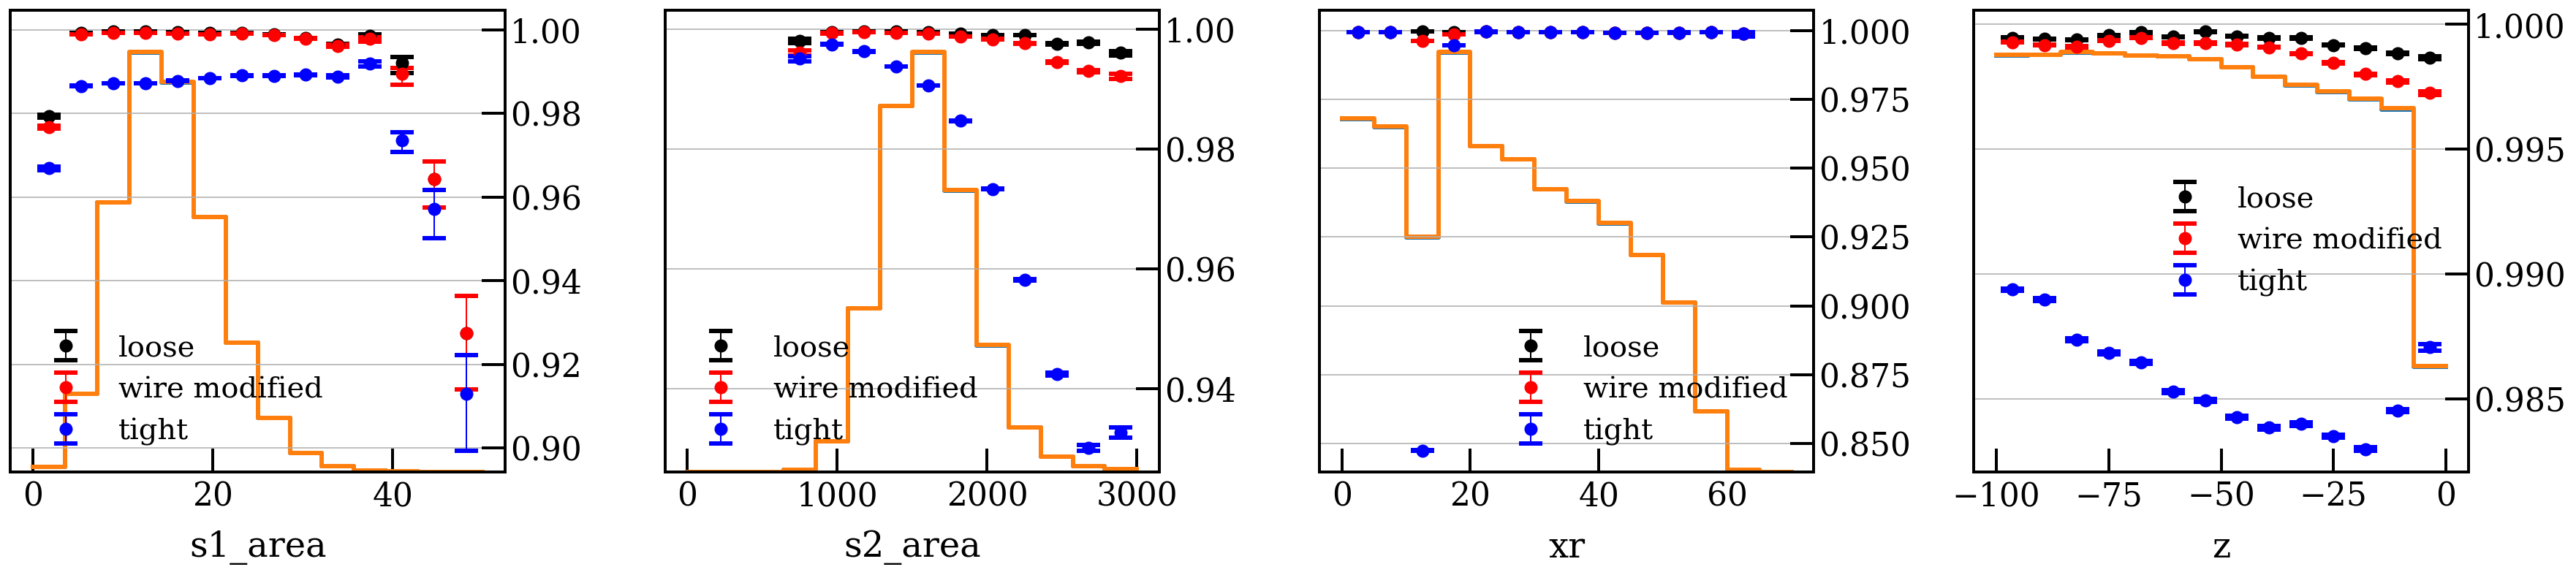

In [75]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6), sharey=False)

s1_area_bins = np.linspace(0, 50, num=15)
s2_area_bins = np.linspace(0, 3000, num=15)

s1_bins_center = c(s1_area_bins)
s2_bins_center = c(s2_area_bins)

data_ar['xr'] = np.abs(data_ar['s2_x_mlp'] * np.cos(-np.pi/6) + data_ar['s2_y_mlp'] * np.sin(-np.pi/6))
data_ar['r2'] = data_ar['y'] ** 2 + data_ar['x'] ** 2
data = data_ar
diagnostic_plot = True
for ix, x_var in enumerate(('s1_area', 's2_area', 'xr', 'z')[:]):
    plt.sca(axes[ix])
    axt = plt.gca().twinx()

    ls = []
    for iy in range(3):
        plt.sca(axes[ix])
        if iy == 0:
            sel_all = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width_mod']) & (data['z'] < -5)
        if iy == 1:
            sel_all = apply_all_except(data, cuts_in_use_mod) & (data['z'] < -5)
        if iy == 2:
            sel_all = apply_all_except(data, cuts_in_use_mod) & (data['z'] < -5) & data['cut_s2_width_tight']
        
        sel_n_1 = apply_all_except(data, cuts_in_use_mod, ['cut_s2_width', 'cut_s2_width_mod'])  & (data['z'] < -5)

        pha = Hist1d(data[x_var][sel_all], bins=eval(x_var+'_bins'))
        pht = Hist1d(data[x_var][sel_n_1], bins=eval(x_var+'_bins'))

        if diagnostic_plot:
            if iy == 1:
                pha.plot()
                pht.plot()

                axes[ix].set_ylim(0, np.max(pht[:])*1.1)
                axes[ix].get_yaxis().set_visible(False)

            plt.xlabel(x_var)
            plt.sca(axt)

        ci_low = np.zeros(len(pha[:]))
        ci_upp = np.zeros(len(pha[:]))
        for j in range(len(pha)):
             ci_low[j], ci_upp[j] = sm_interval(pha[j], pht[j], alpha=0.9, method='beta')

        if ix <= 1:
            x = eval(x_var[:-5]+'_bins_center')
        else:
            x = eval(x_var[:]+'_bins_center')
        y = pha[:] / pht[:]
        ci_low = y - ci_low
        ci_upp = ci_upp - y
        yerr = np.array([ci_low, ci_upp])
        l = plt.errorbar(x, y, yerr, lw=1, fmt='.', alpha=1, color=['k', 'r', 'b'][iy], )
        ls.append(l)

    plt.grid()
    plt.xlabel(x_var)
    plt.legend(ls, ['loose', 'wire modified', 'tight'], fontsize='small')

    # if ix <= 1:
    #     plt.xscale('log')

plt.tight_layout()


In [76]:
## Try loading ac
ac = pd.read_hdf('/dali/lgrandi/xudc/ac_0104.h5', key='fold3_df', start=0, stop=int(1e4))

In [77]:
ac['s2_area_fraction_top'] = 0.75
ac['s2_x_cnn'] = ac['s2_x']
ac['s2_y_cnn'] = ac['s2_y']

In [78]:
ac['cut_s2_width_mod'] = s2w.cut_by(ac)
ac['cut_s2_width_tight'] = s2wt.cut_by(ac)

In [83]:
cuts_in_use_ac = [c for c in ac.columns if 'cut' in c]
cuts_in_use_ac = [c for c in cuts_in_use_ac if not c in 
               ['cut_fiducial_volume', 'cut_near_wires', 'cut_s1_max_pmt', 'cut_s2_width_tight']]
cuts_in_use_ac

['cut_cs2_area_fraction_top',
 'cut_interaction_exists',
 'cut_pairing_exists',
 'cut_s1_area_fraction_top',
 'cut_s1_single_scatter',
 'cut_s2_recon_pos_diff',
 'cut_s2_single_scatter',
 'cut_s2_width',
 'cut_shadow',
 'cut_s2_width_mod']

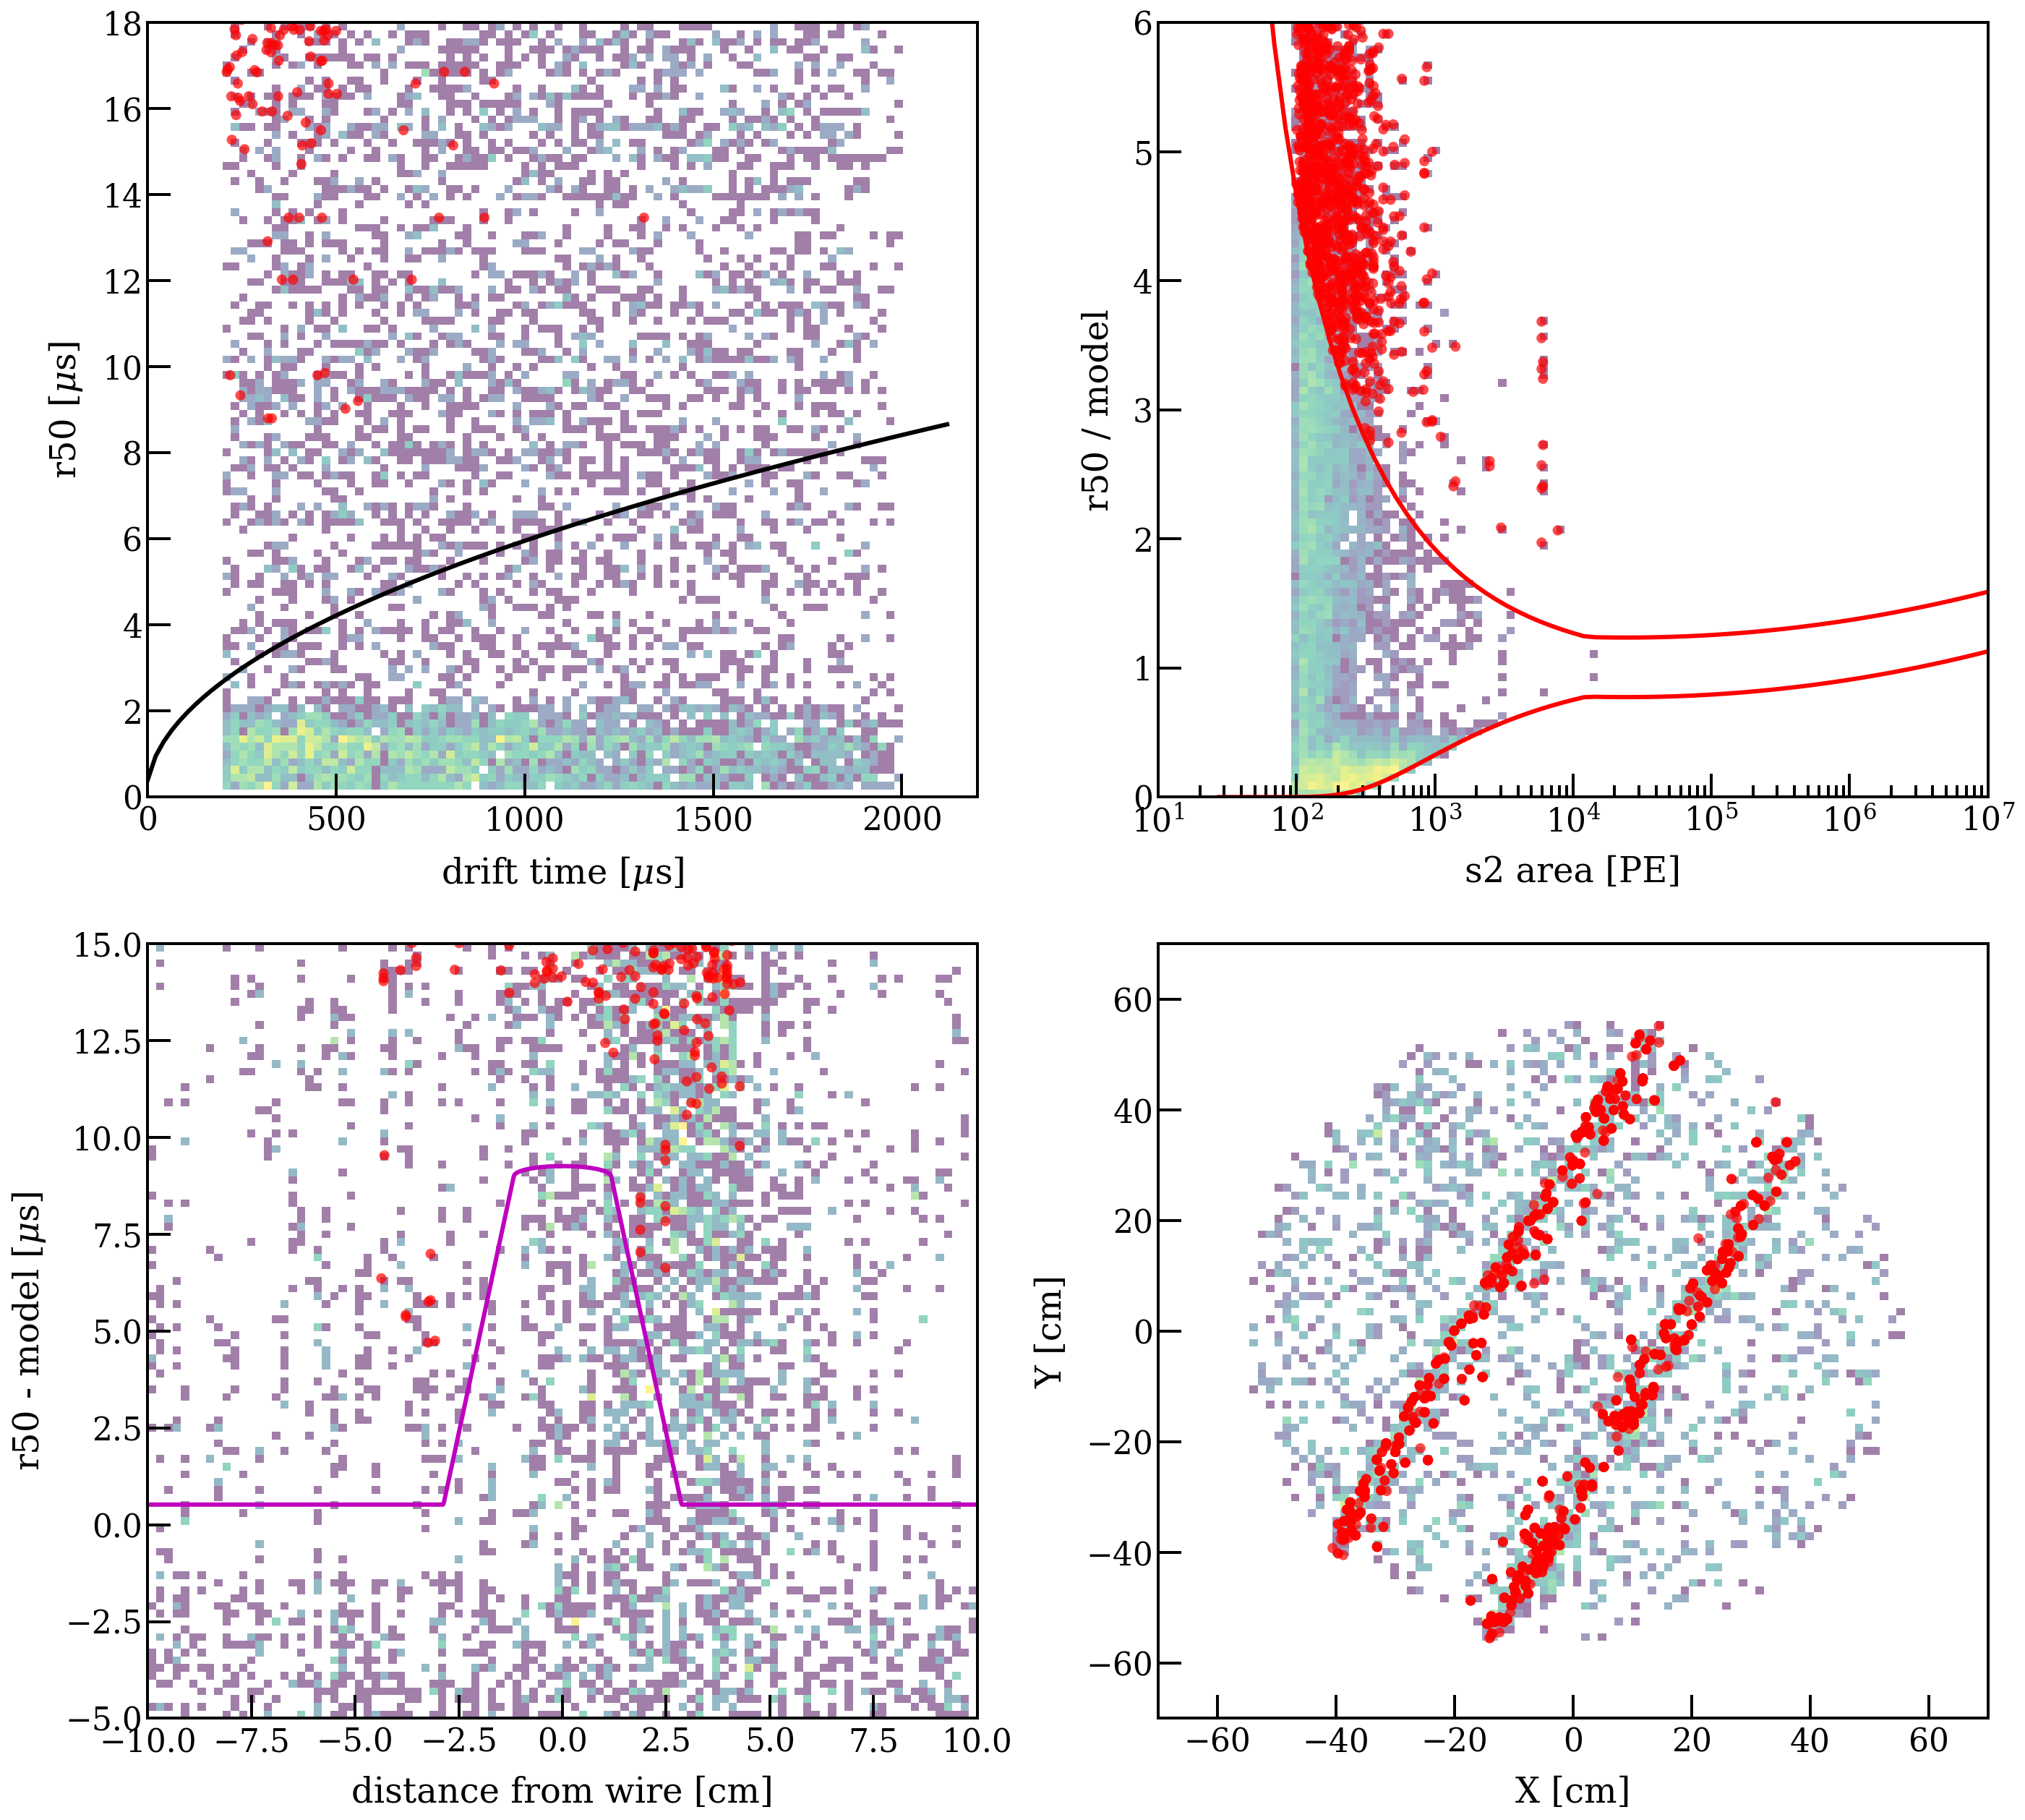

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

hist = True
# A
plt.sca(axes[0][0])

xbin = [0, 2.2e3, 101]
#xbin = [0, 300, 101]
ybin = [0, 18, 101]

mask_string = """
masks = apply_all_except(data, cuts_in_use_ac, ['cut_not_near_wires', 'cut_s2_width_mod']), \
        apply_all_except(data, cuts_in_use_ac, ['cut_not_near_wires', '~cut_s2_width_mod'])
masks = [m & (data['drift_time']/1e3 < 2e3) for m in masks]
"""

mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
for jx, data in enumerate([ac]):
    exec(mask_string)
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['drift_time'][m] / 1e3, data['s2_range_50p_area'][m] / 1e3)
        if (not hist) or ix == 1:
            plt.scatter(data['drift_time'][m] / 1e3, 
                        data['s2_range_50p_area'][m] / 1e3, 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )
mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
dt = np.linspace(0, 2.12e6, 101)
plt.plot(dt / 1e3, s2w.s2_width_model(dt) / 1e3, color='k')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])

plt.xlabel('drift time [$\mu$s]')
plt.ylabel('r50 [$\mu$s]')


# B
plt.sca(axes[0][1])
xbin = [1, 7, 101]
ybin = [0, 6, 101]

mh =  Histdd([], [], bins=[np.logspace(*xbin), np.linspace(*ybin)])
for jx, data in enumerate([ac]):
    exec(mask_string)
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['s2_area'][m], data['s2_range_50p_area'][m] / s2w.s2_width_model(data['drift_time'][m]))
        if (not hist) or ix == 1:
            plt.scatter(data['s2_area'][m], 
                        data['s2_range_50p_area'][m] / s2w.s2_width_model(data['drift_time'][m]), 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )
mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)


s2_area = np.logspace(0, 8, 101)
plt.plot(s2_area, np.select([s2_area <= s2w.config['switch_from_chi2'], s2_area > s2w.config['switch_from_chi2']],
                            [s2w.cut_chi2(s2_area, True), s2w.cut_parabola(s2_area, *s2w.config['param_parabola_high'])], 1), 
         color='r')

plt.plot(s2_area, np.select([s2_area <= s2w.config['switch_from_chi2'], s2_area > s2w.config['switch_from_chi2']],
                            [s2w.cut_chi2(s2_area, False), s2w.cut_parabola(s2_area, *s2w.config['param_parabola_low'])], 1), 
         color='r')

plt.xlim(10**np.array(xbin[:2]))
plt.ylim(ybin[:2])

plt.xscale('log')
plt.xlabel('s2 area [PE]')
plt.ylabel('r50 / model')


# C
plt.sca(axes[1][0])
xbin = [-10, 10, 101]
ybin = [-5, 15, 101]

for jx, data in enumerate([ac]):
    exec(mask_string)
    data['x_to_wire'] = np.abs(data['s2_x_cnn'] * np.cos(-np.pi/6) + data['s2_y_cnn'] * np.sin(-np.pi/6)) - 13.2
    mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['x_to_wire'][m], (data['s2_range_50p_area'][m] - s2w.s2_width_model(data['drift_time'][m])) / 1e3,)
        if (not hist) or ix == 1:
            plt.scatter(data['x_to_wire'][m],
                        (data['s2_range_50p_area'][m] - s2w.s2_width_model(data['drift_time'][m])) / 1e3, 
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )

mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
x2w = np.linspace(-10, 10, 1001)
x1 = np.ones_like(x2w)
plt.plot(x2w, s2w.uppper_lim_with_wire(x1 * s2w.s2_width_model(100e3), 
                                       x1 * s2w.cut_chi2(1e4, True), 
                                       x1 * 1e4 * 0.75, x2w) / 1e3, color='m')
    
plt.xlabel('distance from wire [cm]')
plt.ylabel('r50 - model [$\mu$s]')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])


# D
plt.sca(axes[1][1])
xbin = [-70, 70, 101]
ybin = [-70, 70, 101]

for jx, data in enumerate([ac]):
    exec(mask_string)
    mh =  Histdd([], [], bins=[np.linspace(*xbin), np.linspace(*ybin)])
    for ix, m in enumerate(masks):
        if hist and (ix == 0):
            mh.add(data['s2_x'][m], data['s2_y'][m],)
                
        if (not hist) or ix == 1:
            plt.scatter(data['s2_x'][m],
                        data['s2_y'][m],
                        s=50, color=['r', 'b'][jx], alpha=0.7, ec='none'
                       )

mh.plot(cmap='viridis', colorbar=False, alpha=0.5, log_scale=True, zorder=0)
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')

plt.xlim(xbin[:2])
plt.ylim(ybin[:2])

plt.tight_layout()
plt.show()

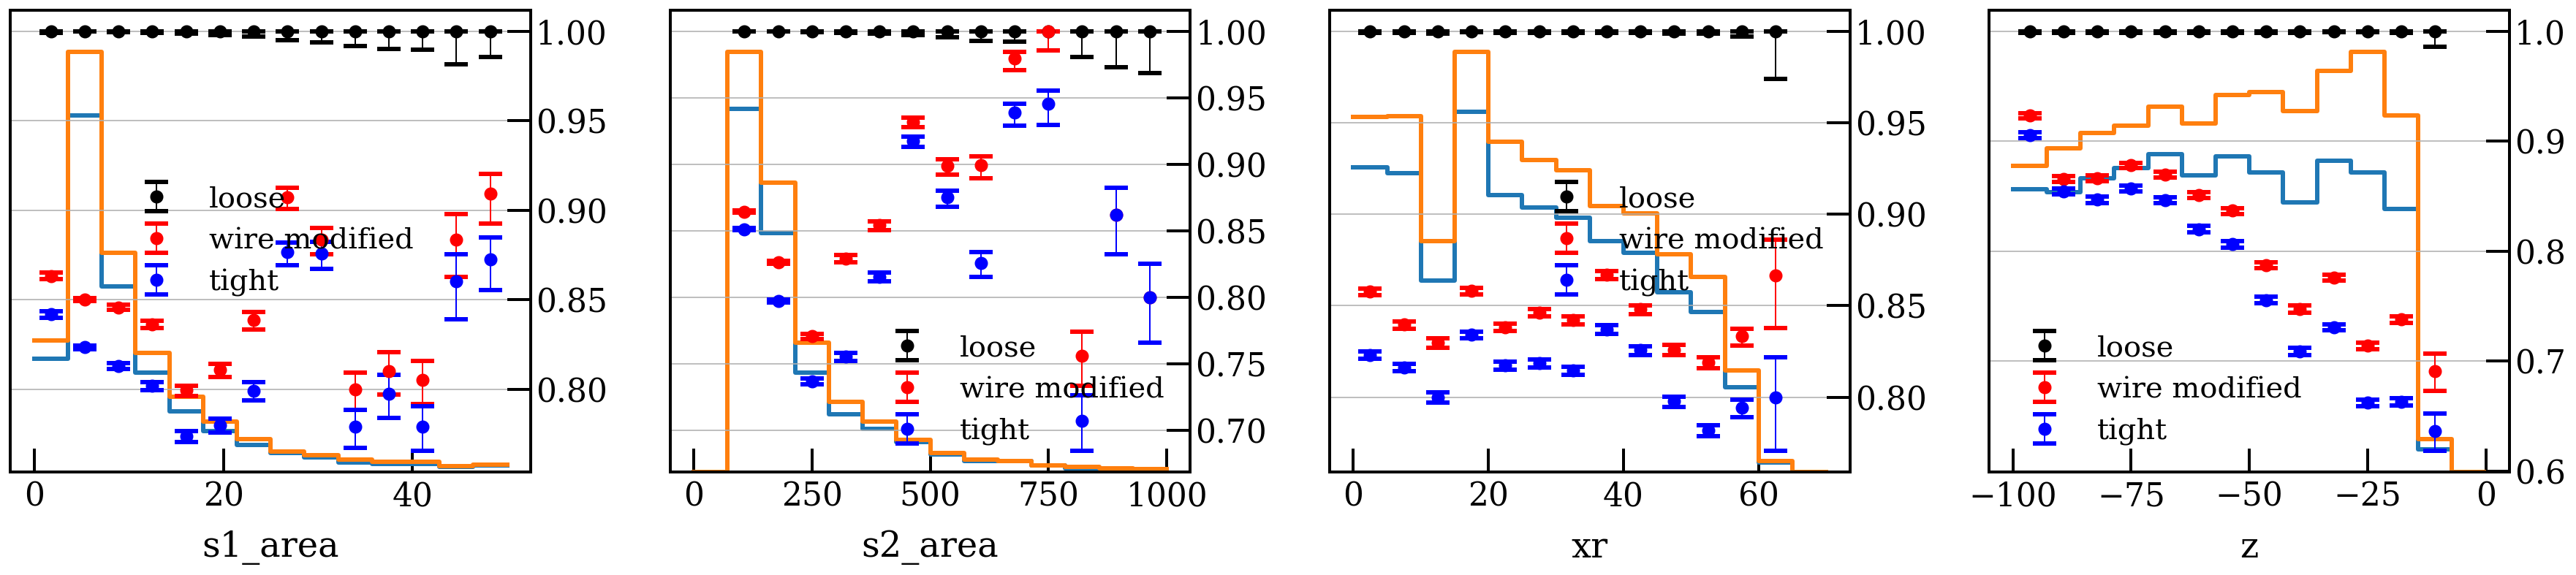

In [85]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6), sharey=False)

s1_area_bins = np.linspace(0, 50, num=15)
s2_area_bins = np.linspace(0, 1000, num=15)

s1_bins_center = c(s1_area_bins)
s2_bins_center = c(s2_area_bins)

ac['xr'] = np.abs(data_ar['s2_x'] * np.cos(-np.pi/6) + data_ar['s2_y'] * np.sin(-np.pi/6))
data = ac
diagnostic_plot = True
for ix, x_var in enumerate(('s1_area', 's2_area', 'xr', 'z')[:]):
    plt.sca(axes[ix])
    axt = plt.gca().twinx()

    ls = []
    for iy in range(3):
        plt.sca(axes[ix])
        if iy == 0:
            sel_all = apply_all_except(data, cuts_in_use_ac, ['cut_s2_width_mod']) & (data['z'] < -5)
        if iy == 1:
            sel_all = apply_all_except(data, cuts_in_use_ac) & (data['z'] < -5)
        if iy == 2:
            sel_all = apply_all_except(data, cuts_in_use_ac) & (data['z'] < -5) & data['cut_s2_width_tight']
        
        sel_n_1 = apply_all_except(data, cuts_in_use_ac, ['cut_s2_width', 'cut_s2_width_mod'])  & (data['z'] < -5)

        pha = Hist1d(data[x_var][sel_all], bins=eval(x_var+'_bins'))
        pht = Hist1d(data[x_var][sel_n_1], bins=eval(x_var+'_bins'))

        if diagnostic_plot:
            if iy == 1:
                pha.plot()
                pht.plot()

                axes[ix].set_ylim(0, np.max(pht[:])*1.1)
                axes[ix].get_yaxis().set_visible(False)

            plt.xlabel(x_var)
            plt.sca(axt)

        ci_low = np.zeros(len(pha[:]))
        ci_upp = np.zeros(len(pha[:]))
        for j in range(len(pha)):
             ci_low[j], ci_upp[j] = sm_interval(pha[j], pht[j], alpha=0.9, method='beta')

        if ix <= 1:
            x = eval(x_var[:-5]+'_bins_center')
        else:
            x = eval(x_var[:]+'_bins_center')
        y = pha[:] / pht[:]
        ci_low = y - ci_low
        ci_upp = ci_upp - y
        yerr = np.array([ci_low, ci_upp])
        l = plt.errorbar(x, y, yerr, lw=1, fmt='.', alpha=1, color=['k', 'r', 'b'][iy], )
        ls.append(l)

    plt.grid()
    plt.xlabel(x_var)
    plt.legend(ls, ['loose', 'wire modified', 'tight'], fontsize='small',)

    # if ix <= 1:
    #     plt.xscale('log')

plt.tight_layout()